In [1]:
from recon_lidar_error_stat import init, getData, np, mean_squared_error, datetime, plt, joblib, calculate_1d_kernel_density
import recon_lidar_error_stat
import warnings
warnings.filterwarnings("ignore")

In [2]:
recon_lidar_error_stat.init()

In [3]:
def transfer_model(from_site_abbr, to_site_abbr, from_date_time, to_date_time, shift=True, with_swe=False, stat=True):
    test_feature, test_y = getData(to_site_abbr, to_date_time, shift=shift, with_swe=with_swe)
    rf_model_fn = "regression_models/" + from_site_abbr + "_" + from_date_time.strftime("%y_%m_%d") + "_"
    if shift:
        rf_model_fn = "regression_models/" + from_site_abbr + "_" + from_date_time.strftime("%y_%m_%d") + "_shift_"
    if with_swe:
        rf_model_fn += "swe_rf.p"
    else:
        rf_model_fn += "rf.p"
    rf_model = joblib.load(rf_model_fn)
    predict_y = rf_model.predict(test_feature)
    if stat:
        return np.corrcoef(test_y, predict_y), np.sqrt(mean_squared_error(test_y, predict_y))
    else:
        return predict_y, test_y

In [4]:
def transfer_model_temporal_corr_rmse(site_abbr, with_swe=False):
    if site_abbr == "MB":
        site_date_time = recon_lidar_error_stat.merced_date_list
    else:
        site_date_time = recon_lidar_error_stat.tuolumne_date_list
    corr_mat = np.zeros((len(site_date_time), len(site_date_time)))
    rmse_mat = np.zeros((len(site_date_time), len(site_date_time)))
    for i, from_date_time in enumerate(site_date_time):
        for j, to_date_time in enumerate(site_date_time):
            corr, rmse = transfer_model(site_abbr, 
                                        site_abbr, 
                                        from_date_time, 
                                        to_date_time, 
                                        shift=True, 
                                        with_swe=with_swe)
            corr_mat[i, j] = corr[0, 1]
            rmse_mat[i, j] = rmse
    plt.imshow(corr_mat, interpolation='nearest', cmap=plt.get_cmap("Oranges"), vmin=0.7, vmax=1.0)
    plt.colorbar()
    plt.show()
    plt.imshow(rmse_mat, interpolation='nearest', cmap=plt.get_cmap("Oranges"), vmin=0.05, vmax=0.2)
    plt.colorbar()
    plt.show()

In [5]:
def transfer_model_temporal_error_density(site_abbr, with_swe=False):
    if site_abbr == "MB":
        site_date_time = recon_lidar_error_stat.merced_date_list
    else:
        site_date_time = recon_lidar_error_stat.tuolumne_date_list
    fig, axarr = plt.subplots(ncols=len(site_date_time), nrows=len(site_date_time), figsize=(12, 9))
    for i, from_date_time in enumerate(site_date_time):
        for j, to_date_time in enumerate(site_date_time):
            predict_y, test_y = transfer_model(site_abbr,
                                               site_abbr,
                                               from_date_time,
                                               to_date_time,
                                               shift=True,
                                               with_swe=with_swe,
                                               stat=False)
            linspace = np.linspace(-0.5, 0.5, 200)[:, np.newaxis]
            test_y_density = calculate_1d_kernel_density(test_y, linspace)
            predict_y_density = calculate_1d_kernel_density(test_y-predict_y, linspace)
            axarr[i, j].plot(linspace, test_y_density)
            axarr[i, j].plot(linspace, predict_y_density)
            from_date_str = from_date_time.strftime("%Y-%m-%d")
            to_date_str = to_date_time.strftime("%Y-%m-%d")
            if j == 0:
                axarr[i, j].set_ylabel(from_date_str)
            if i == 0:
                axarr[i ,j].set_title(to_date_str)
            if i == 0 and j == 0:
                axarr[i, j].legend(["Original", "Corrected"], prop={'size':6})
    plt.show()

Below is the figure showing the error kernel density of transfering the model to different dates when the feature __does not include__ the current reconstructed SWE

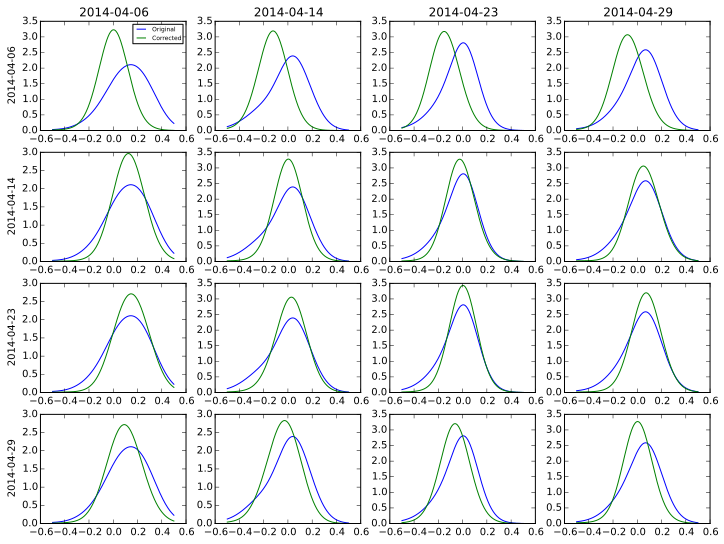

In [ ]:
transfer_model_temporal_error_density("MB", with_swe=False)

Below is the figure showing the error kernel density of transfering the model to different dates when the feature __does include__ the current reconstructed SWE

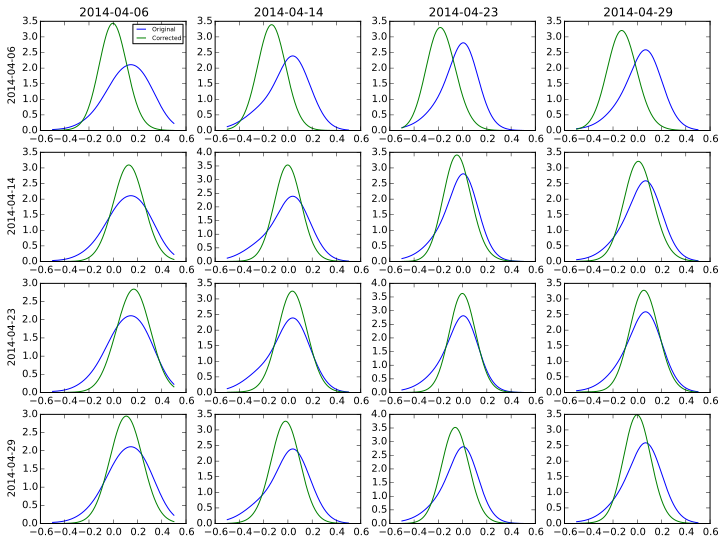

In [6]:
transfer_model_temporal_error_density("MB", with_swe=True)

Below is the figure showing of correlation and rmse of transfering the model to different dates when the feature __does not include__ the current reconstructed SWE

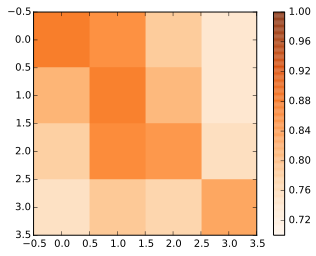

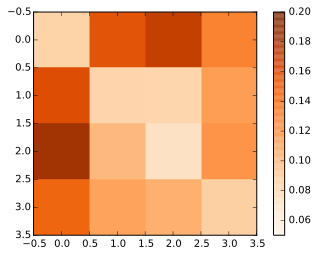

In [5]:
transfer_model_temporal_corr_rmse("MB")

Below is the figure showing of correlation and rmse of transfering the model to different dates when the feature __include__ the current reconstructed SWE

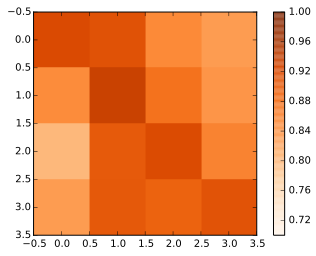

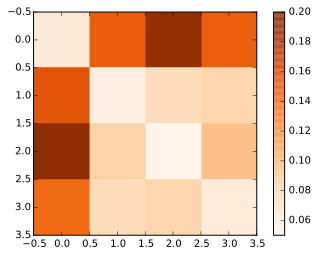

In [6]:
transfer_model_temporal_("MB", with_swe=True)